<a href="https://colab.research.google.com/github/kiercvelasco/Deep-Learning/blob/main/svhn_on_3_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***SVHN Classifier using 3 Networks***

In this notebook the SVHN dataset cropped digits format (http://ufldl.stanford.edu/housenumbers/) was used to train 3 different classifiers using 3 different pretrained networks: resnet50d, densenet121, and mobilenet_v3. All three models were imported from the timm module.
The notebook was created and run via Google Colab.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
pip install timm

     |████████████████████████████████| 245kB 7.7MB/s 


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
import timm
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import scipy
import copy

#device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
print(torch.cuda.is_available())

True


In [5]:
mean = np.array([0.4377, 0.4438, 0.4728])
std = np.array([0.1980, 0.2010, 0.1970])

pre_processing = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

#loading dataset
root = '/content/gdrive/My Drive/Deep Learning/Datasets/SVHN-dataset'
sets = ['train', 'test']
image_datasets = {x: datasets.SVHN(root=os.path.join(root, x), split=x, transform=pre_processing)
                 for x in sets}

data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                              shuffle=True, num_workers=0)
               for x in sets}

dataset_sizes = {x: len(image_datasets[x]) for x in sets}

Mean and standard deviantion used was calculated separately using the SVHN dataset.
The SVHN dataset was loaded using the SVHN function from torchvision. This function automatically changes the labeling of the 0 digit from 10 to 0.

The train_model function runs both training and testing of the model. It prints out the loss and accuracy for every epoch during training and also stores train and test data to lists for later use.
The function saves the state of the model everytime it detects an improvement to its accuracy This saved model is what is returned at the end of the training ensuring that the final model is the best model possible from training.

In [6]:
def train_model(model, criterion, optimizer, scheduler, loss_vals, acc_vals, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)
        
        for phase in sets:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
            
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                    
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
        
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            loss_vals[phase].append(epoch_loss)
            acc_vals[phase].append(epoch_acc)
        
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_mode_wts = copy.deepcopy(model.state_dict())
        
        print()
        
    time_elapsed = time.time() - since
    print(f'Training completed in {time_elapsed//60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    model.load_state_dict(best_model_wts)
    
    return model

The following cell is class definitions for each of the 3 models (resnet50d, densenet121, and mobilenet_v3). The classifier layer of each models are replaced with a custom classifier for the SVHN dataset.

The custom classifier is composed of a liner input layer where BatchNorm and Dropout is applied followed by 2 linear layers. The input size of the input layer is taken from the input size of the each models original classifier. the sizes are halfed every time we go down a layer until the output layer where the output is set to 10.

In [7]:
#resnet50d
class Resnet50d(nn.Module):
    def __init__(self):
        super(Resnet50d, self).__init__()
        self.model = timm.create_model('resnet50d', pretrained=True)
        self.classifier_layer = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.Linear(512, 10)
        )
    
    def forward(self, x):
        x = self.model.forward_features(x)
        x = self.model.global_pool(x)
        if self.model.drop_rate:
            x = F.dropout(x, p=float(self.model.drop_rate), training=self.model.training)
        x = self.classifier_layer(x)
        return x
    
#densenet121
class Densenet121(nn.Module):
    def __init__(self):
        super(Densenet121, self).__init__()
        self.model = timm.create_model('densenet121', pretrained=True)
        self.classifier_layer = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.Linear(256, 10)
        )
    
    def forward(self, x):
        x = self.model.forward_features(x)
        x = self.model.global_pool(x)
        # both classifier and block drop?
        # if self.drop_rate > 0.:
        #     x = F.dropout(x, p=self.drop_rate, training=self.training)
        x = self.classifier_layer(x)
        return x
    
#mobilenet_v3
class Mobilenet_v3(nn.Module):
    def __init__(self):
        super(Mobilenet_v3, self).__init__()
        self.model = timm.create_model('mobilenetv3_rw', pretrained=True)
        self.classifier_layer = nn.Sequential(
            nn.Linear(1280, 640),
            nn.BatchNorm1d(640),
            nn.Dropout(0.2),
            nn.Linear(640, 320),
            nn.Linear(320, 10)
        )
    
    def forward(self, x):
        x = self.model.forward_features(x)
        if not self.model.global_pool.is_identity():
            x = x.flatten(1)
        if self.model.drop_rate > 0.:
            x = F.dropout(x, p=self.model.drop_rate, training=self.model.training)
        return self.classifier_layer(x)

The following cells executes the training of the models using cross entropy loss, Adam optimizer, and stepLR learning rate scheduler.

In [8]:
#train resnet50d
model_R50d = Resnet50d()
model_R50d.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_R50d.parameters(), lr=0.001)

R50d_loss = {'train': [], 'test' : []}
R50d_acc = {'train' : [], 'test' : []}

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model_R50d = train_model(model_R50d, criterion, optimizer, step_lr_scheduler, R50d_loss, R50d_acc, num_epochs=20)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50d_ra2-464e36ba.pth" to /root/.cache/torch/hub/checkpoints/resnet50d_ra2-464e36ba.pth


Epoch 0/19
----------
train Loss: 0.7369 Acc: 0.7752
test Loss: 0.2670 Acc: 0.9271

Epoch 1/19
----------
train Loss: 0.2942 Acc: 0.9198
test Loss: 0.2346 Acc: 0.9381

Epoch 2/19
----------
train Loss: 0.2362 Acc: 0.9379
test Loss: 0.2378 Acc: 0.9366

Epoch 3/19
----------
train Loss: 0.1933 Acc: 0.9480
test Loss: 0.2074 Acc: 0.9463

Epoch 4/19
----------
train Loss: 0.1742 Acc: 0.9537
test Loss: 0.2168 Acc: 0.9411

Epoch 5/19
----------
train Loss: 0.1552 Acc: 0.9590
test Loss: 0.2236 Acc: 0.9440

Epoch 6/19
----------
train Loss: 0.1307 Acc: 0.9648
test Loss: 0.2269 Acc: 0.9486

Epoch 7/19
----------
train Loss: 0.0552 Acc: 0.9854
test Loss: 0.1790 Acc: 0.9583

Epoch 8/19
----------
train Loss: 0.0299 Acc: 0.9925
test Loss: 0.1931 Acc: 0.9587

Epoch 9/19
----------
train Loss: 0.0166 Acc: 0.9955
test Loss: 0.2268 Acc: 0.9569

Epoch 10/19
----------
train Loss: 0.0089 Acc: 0.9974
test Loss: 0.2852 Acc: 0.9560

Epoch 11/19
----------
train Loss: 0.0060 Acc: 0.9981
test Loss: 0.3027 Acc

In [10]:
#train densenet121
model_D121 = Densenet121()
model_D121.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_D121.parameters(), lr=0.001)

D121_loss = {'train': [], 'test' : []}
D121_acc = {'train' : [], 'test' : []}

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_D121 = train_model(model_D121, criterion, optimizer, step_lr_scheduler, D121_loss, D121_acc, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.6125 Acc: 0.8153
test Loss: 0.2944 Acc: 0.9134

Epoch 1/19
----------
train Loss: 0.3588 Acc: 0.9021
test Loss: 0.2642 Acc: 0.9287

Epoch 2/19
----------
train Loss: 0.3464 Acc: 0.9041
test Loss: 0.2548 Acc: 0.9296

Epoch 3/19
----------
train Loss: 0.2418 Acc: 0.9339
test Loss: 0.2186 Acc: 0.9387

Epoch 4/19
----------
train Loss: 0.2249 Acc: 0.9406
test Loss: 0.2742 Acc: 0.9326

Epoch 5/19
----------
train Loss: 0.2268 Acc: 0.9390
test Loss: 0.2249 Acc: 0.9398

Epoch 6/19
----------
train Loss: 0.1735 Acc: 0.9519
test Loss: 0.2311 Acc: 0.9374

Epoch 7/19
----------
train Loss: 0.0932 Acc: 0.9747
test Loss: 0.1772 Acc: 0.9539

Epoch 8/19
----------
train Loss: 0.0637 Acc: 0.9833
test Loss: 0.1768 Acc: 0.9551

Epoch 9/19
----------
train Loss: 0.0467 Acc: 0.9882
test Loss: 0.1965 Acc: 0.9544

Epoch 10/19
----------
train Loss: 0.0336 Acc: 0.9912
test Loss: 0.2151 Acc: 0.9530

Epoch 11/19
----------
train Loss: 0.0234 Acc: 0.9940
test Loss: 0.2567 Acc

In [11]:
#train mobilenetv3_rw
model_Mv3 = Mobilenet_v3()
model_Mv3.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_Mv3.parameters(), lr=0.001)

Mv3_loss = {'train': [], 'test' : []}
Mv3_acc = {'train' : [], 'test' : []}

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_Mv3 = train_model(model_Mv3, criterion, optimizer, step_lr_scheduler, Mv3_loss, Mv3_acc, num_epochs=20)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/mobilenetv3_100-35495452.pth" to /root/.cache/torch/hub/checkpoints/mobilenetv3_100-35495452.pth


Epoch 0/19
----------
train Loss: 0.9079 Acc: 0.7030
test Loss: 0.4281 Acc: 0.8714

Epoch 1/19
----------
train Loss: 0.4003 Acc: 0.8804
test Loss: 0.3140 Acc: 0.9095

Epoch 2/19
----------
train Loss: 0.3145 Acc: 0.9072
test Loss: 0.3007 Acc: 0.9140

Epoch 3/19
----------
train Loss: 0.2619 Acc: 0.9235
test Loss: 0.2647 Acc: 0.9219

Epoch 4/19
----------
train Loss: 0.2302 Acc: 0.9331
test Loss: 0.2848 Acc: 0.9187

Epoch 5/19
----------
train Loss: 0.2048 Acc: 0.9412
test Loss: 0.3044 Acc: 0.9148

Epoch 6/19
----------
train Loss: 0.1932 Acc: 0.9444
test Loss: 0.2781 Acc: 0.9235

Epoch 7/19
----------
train Loss: 0.0972 Acc: 0.9722
test Loss: 0.2425 Acc: 0.9365

Epoch 8/19
----------
train Loss: 0.0684 Acc: 0.9812
test Loss: 0.2574 Acc: 0.9370

Epoch 9/19
----------
train Loss: 0.0511 Acc: 0.9861
test Loss: 0.2824 Acc: 0.9344

Epoch 10/19
----------
train Loss: 0.0375 Acc: 0.9899
test Loss: 0.3109 Acc: 0.9312

Epoch 11/19
----------
train Loss: 0.0294 Acc: 0.9920
test Loss: 0.3252 Acc

The following cell plots the train and test data of all 3 models during training.

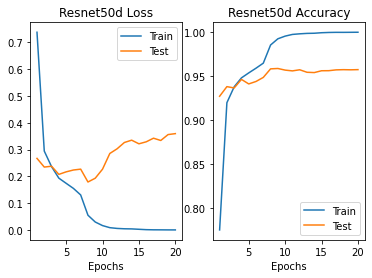

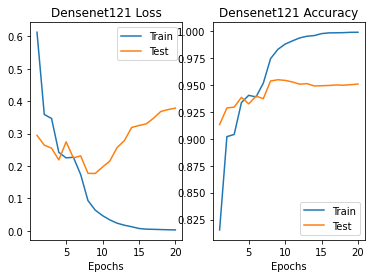

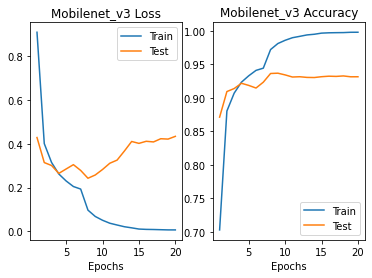

In [48]:
x_axis = np.linspace(1, len(R50d_loss['train']), len(R50d_loss['train']))
#Resnet50D plots
plt.figure()

plt.subplot(121)
plt.plot(x_axis, R50d_loss['train'], label='Train')
plt.plot(x_axis, R50d_loss['test'], label='Test')
plt.legend()
plt.xlabel('Epochs')
plt.title('Resnet50d Loss')

plt.subplot(122)
plt.plot(x_axis, R50d_acc['train'], label='Train')
plt.plot(x_axis, R50d_acc['test'], label='Test')
plt.legend()
plt.xlabel('Epochs')
plt.title('Resnet50d Accuracy')

#Densenet121 plots
plt.figure()

plt.subplot(121)
plt.plot(x_axis, D121_loss['train'], label='Train')
plt.plot(x_axis, D121_loss['test'], label='Test')
plt.legend()
plt.xlabel('Epochs')
plt.title('Densenet121 Loss')

plt.subplot(122)
plt.plot(x_axis, D121_acc['train'], label='Train')
plt.plot(x_axis, D121_acc['test'], label='Test')
plt.legend()
plt.xlabel('Epochs')
plt.title('Densenet121 Accuracy')

#Mobilenetv3 plots
plt.figure()

plt.subplot(121)
plt.plot(x_axis, Mv3_loss['train'], label='Train')
plt.plot(x_axis, Mv3_loss['test'], label='Test')
plt.legend()
plt.xlabel('Epochs')
plt.title('Mobilenet_v3 Loss')

plt.subplot(122)
plt.plot(x_axis, Mv3_acc['train'], label='Train')
plt.plot(x_axis, Mv3_acc['test'], label='Test')
plt.legend()
plt.xlabel('Epochs')
plt.title('Mobilenet_v3 Accuracy')

plt.show()

We can see from the graphs that before epoch 10 the test loss stops improving and actually starts increasing, which is most likely caused by overfitting.
At around the same point the test accuracy for all models reach their highest value and then starts to platue at a lesser value.
The training function already saves the model at the highest point of the test accuracy so Early Stopping is no longer required unless we want to make training faster.

After training Resnet50d, Densenet121, and Mobilenetv3 on the SVHN core for 20 epochs, we achieved the following:

|Model          |Best Accuracy |
|---------------|--------------|
|resnet50d      |95.87%        |
|               |              |
|densenet121    |95.50%        |
|               |              |
|mobilenetv3    |93.70%        |